# Задача 5 (бонусная): экспериментальное исследование алгоритмов для регулярных запросов #

## Подготовка окружения ##

Note: Linux only

Установка необходимых зависимостей:

In [1]:
!pip install -r requirements.txt

In [2]:
!pip install pycubool matplotlib

## Введение 
В эксперименте рассматривается задача достижимости в графе с регулярными ограничениями. Используем библиотеки для работы с разреженными матрицами [scipy.sparse](https://github.com/scipy/scipy) и [pycubool](https://github.com/JetBrains-Research/cuBool) для исследования производительности решений.

### О задаче достижимости 
Пусть дан конечный ориентированный помеченный граф $G = (V, E, L)$. Каждому пути $\pi \in E^*$, состоящему из рёбер с метками $l_1, ..., l_n \in L$, сопоставляется слово по правилу $\omega(\pi) = l_1 + ... + l_n$, где $+$ --- конкатенация.

Возьмем $R$ --- регулярное выражение.

Рассмотрим следующие варианты:

#### 1. Достижимость между всеми парами вершин
Необходимо найти пары вершин $G$, такие, что между ними существует путь, которому сопоставляется слово из языка, задаваемого $R$. 
Далее обозначим $V_S$ множество стартовых вершин, $V_F$ множество финальных вершин. 

#### 2. Достижимость для всего множества заданных вершин

Необходимо найти все финальные вершины, такие, что до них существуют пути из стартовых, которым сопоставляются слова из языка, задаваемого $R$.

#### 3. Достижимость для каждой вершины из заданного множества стартовых вершин

Необходимо найти множество пар вершин-начал и вершин-концов путей, которым сопоставляются слова из языка, задаваемого $R$ 





## Исследуемые решения ##

Рассмотрим краткие идеи решения каждой задачи:

#### 1. Достижимость между всеми парами вершин
По графу и регулярному выражению строятся конечные автоматы, представленные в виде разреженных булевых матриц, а затем ищется их пересечение с помощью тензорного произведения. Финальном шагом является подсчет транзитивного замыкания пересечения автоматов.

#### 2. Достижимость для всего множества заданных вершин ####
Аналогично по графу и регулярному выражению строятся конечные автоматы, а затем производится синхронный поиск в ширину с помощью матричного произведения.

#### 3. Достижимость для каждой вершины из заданного множества стартовых вершин ####
Аналогично задаче 2, однако матрица, отражающая в каких состояниях мы находимся на текущей итерации поиска в ширину имеет расширенный вид, так как необходимо поддерживать информацию для каждой стартовой вершины графа отдельно.




## Реализация

Представленные реализации алгоритмов с помощью библиотек **scipy.sparse** и **pycubool** идентичны. 

На основе **scipy.sparse** представлена в модуле `project.rpq`

In [3]:
from project.rpq import *

На основе **pycubool**:

In [4]:
from typing import Dict, Set, Any, List

from pyformlang.finite_automaton import State, EpsilonNFA

from pycubool import Matrix


class BoolMatrixAutomatonPyCuBool:
    def __init__(
        self,
        state_to_idx: Dict[State, int],
        start_states: Set[State],
        final_states: Set[State],
        b_mtx: Dict[Any, Matrix],
    ):
        self.state_to_idx = state_to_idx
        self.start_states = start_states
        self.final_states = final_states
        self.b_mtx = b_mtx

    def __and__(
        self, other: "BoolMatrixAutomatonPyCuBool"
    ) -> "BoolMatrixAutomatonPyCuBool":
        
        inter_labels = self.b_mtx.keys() & other.b_mtx.keys()
        inter_b_mtx = {
            label: self.b_mtx[label].kronecker(other.b_mtx[label])
            for label in inter_labels
        }
        inter_state_to_idx = dict()
        inter_start_states = set()
        inter_final_states = set()
        for self_state, self_idx in self.state_to_idx.items():
            for other_state, other_idx in other.state_to_idx.items():
                state = State((self_state.value, other_state.value))
                idx = self_idx * len(other.state_to_idx) + other_idx
                inter_state_to_idx[state] = idx
                if (
                    self_state in self.start_states
                    and other_state in other.start_states
                ):
                    inter_start_states.add(state)
                if (
                    self_state in self.final_states
                    and other_state in other.final_states
                ):
                    inter_final_states.add(state)
        return BoolMatrixAutomatonPyCuBool(
            state_to_idx=inter_state_to_idx,
            start_states=inter_start_states,
            final_states=inter_final_states,
            b_mtx=inter_b_mtx,
        )

    def transitive_closure(self) -> Matrix:

        state_count = max(len(self.state_to_idx), 1)
        transitive_closure = Matrix.empty((state_count, state_count))
        for b_mtx in self.b_mtx.values():
            transitive_closure = transitive_closure.ewiseadd(b_mtx)

        prev_nnz, cur_nnz = None, transitive_closure.nvals
        if not cur_nnz:
            return transitive_closure

        while prev_nnz != cur_nnz:
            transitive_closure.mxm(
                transitive_closure, out=transitive_closure, accumulate=True
            )
            prev_nnz, cur_nnz = cur_nnz, transitive_closure.nvals
        return transitive_closure

    @classmethod
    def from_nfa(cls, nfa: EpsilonNFA) -> "BoolMatrixAutomatonPyCuBool":

        state_to_idx = {state: idx for idx, state in enumerate(nfa.states)}
        return cls(
            state_to_idx=state_to_idx,
            start_states=nfa.start_states.copy(),
            final_states=nfa.final_states.copy(),
            b_mtx=cls._b_mtx_from_nfa(
                nfa=nfa,
                state_to_idx=state_to_idx,
            ),
        )

    @staticmethod
    def _b_mtx_from_nfa(
        nfa: EpsilonNFA, state_to_idx: Dict[State, int]
    ) -> Dict[Any, Matrix]:

        b_mtx = dict()
        state_from_to_transitions = nfa.to_dict()
        for label in nfa.symbols:
            mtx = Matrix.empty((len(nfa.states), len(nfa.states)))
            for state_from, transitions in state_from_to_transitions.items():
                states_to = transitions.get(label, set())
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for state_to in states_to:
                    mtx[state_to_idx[state_from], state_to_idx[state_to]] = True
            b_mtx[label] = mtx
        return b_mtx

    def _direct_sum(
        self, other: "BoolMatrixAutomatonPyCuBool"
    ) -> "BoolMatrixAutomatonPyCuBool":

        shifted_state_to_idx = {
            state: len(self.state_to_idx) + idx
            for state, idx in other.state_to_idx.items()
        }
        state_to_idx = {**self.state_to_idx, **shifted_state_to_idx}
        start_states = self.start_states | other.start_states
        final_states = self.final_states | other.final_states
        b_mtx = dict()
        for label in self.b_mtx.keys() & other.b_mtx.keys():
            mtx = Matrix.empty((len(state_to_idx), len(state_to_idx)))
            for i, j in self.b_mtx[label]:
                mtx[i, j] = True
            for i, j in other.b_mtx[label]:
                mtx[len(self.state_to_idx) + i, len(self.state_to_idx) + j] = True
            b_mtx[label] = mtx
        return BoolMatrixAutomatonPyCuBool(
            state_to_idx=state_to_idx,
            start_states=start_states,
            final_states=final_states,
            b_mtx=b_mtx,
        )

    def sync_bfs(
        self,
        other: "BoolMatrixAutomatonPyCuBool",
        reachable_per_node: bool,
    ) -> Set[Any]:

        if not self.state_to_idx or not other.state_to_idx:
            return set()

        ordered_start_states = list(self.start_states)

        direct_sum = other._direct_sum(self)
        initial_front = self._init_sync_bfs_front(
            other=other,
            reachable_per_node=reachable_per_node,
            ordered_start_states=ordered_start_states,
        )

        front = self._copy_mtx(initial_front)
        visited = self._copy_mtx(front)

        other_states_num = len(other.state_to_idx)

        while True:
            visited_nnz = visited.nvals
            new_front = self._copy_mtx(front)

            for _, mtx in direct_sum.b_mtx.items():
                product: Matrix = front.mxm(mtx)
                new_front_step = Matrix.empty(product.shape)
                for i, j in product:
                    if j >= other_states_num:
                        continue
                    row = product[i : i + 1, other_states_num:]
                    if not row.nvals:
                        continue
                    row_shift = i // other_states_num * other_states_num
                    new_front_step[row_shift + j, j] = True
                    for _, rj in row:
                        new_front_step[row_shift + j, other_states_num + rj] = True
                new_front = new_front.ewiseadd(new_front_step)

            new_front_without_visited = Matrix.empty(new_front.shape)
            for i, j in set(new_front.to_list()).difference(set(visited.to_list())):
              new_front_without_visited[i, j] = True

            visited = visited.ewiseadd(new_front_without_visited)
            front = new_front_without_visited

            if visited_nnz == visited.nvals:
                break

        self_idx_to_state = {idx: state for state, idx in self.state_to_idx.items()}
        other_idx_to_state = {idx: state for state, idx in other.state_to_idx.items()}

        result = set()
        nonzero = set(visited.to_list()).difference(set(initial_front.to_list()))
        for i, j in nonzero:
            if (
                other_idx_to_state[i % other_states_num] not in other.final_states
                or j < other_states_num
            ):
                continue
            self_state = self_idx_to_state[j - other_states_num]
            if self_state not in self.final_states:
                continue
            result.add(
                self_state.value
                if not reachable_per_node
                else (
                    ordered_start_states[i // other_states_num].value,
                    self_state.value,
                )
            )
        return result

    @staticmethod
    def _copy_mtx(matrix: Matrix) -> Matrix:
        
        copy = Matrix.empty(matrix.shape)
        for i, j in matrix:
            copy[i, j] = True
        return copy

    def _init_sync_bfs_front(
        self,
        other: "BoolMatrixAutomatonPyCuBool",
        reachable_per_node: bool,
        ordered_start_states: List[State],
    ) -> Matrix:

        def front_with_self_start_row(self_start_row: List):
            front = Matrix.empty(
                (
                    len(other.state_to_idx),
                    len(self.state_to_idx) + len(other.state_to_idx),
                )
            )
            for state in other.start_states:
                idx = other.state_to_idx[state]
                front[idx, idx] = True
                for i, item in enumerate(self_start_row):
                    if item:
                        front[idx, len(other.state_to_idx) + i] = item
            return front

        if not reachable_per_node:
            start_indices = set(
                self.state_to_idx[state] for state in ordered_start_states
            )
            return front_with_self_start_row(
                [idx in start_indices for idx in range(len(self.state_to_idx))]
            )

        fronts = [
            front_with_self_start_row(
                [
                    idx == self.state_to_idx[start]
                    for idx in range(len(self.state_to_idx))
                ]
            )
            for start in ordered_start_states
        ]

        mtx = Matrix.empty(
            (
                len(fronts) * len(other.state_to_idx),
                len(other.state_to_idx) + len(self.state_to_idx),
            )
        )
        for front_number, front in enumerate(fronts):
            for i, j in front:
                mtx[len(other.state_to_idx) * front_number + i, j] = True
        return mtx


In [5]:
from typing import Set, Optional, Tuple, Any, Callable

from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex

from project import (
    graph_to_epsilon_nfa,
    generate_min_dfa_by_regex,
)

def rpq_tensor_pycubool(
    graph: MultiDiGraph,
    query: Regex,
    start_states: Optional[Set],
    final_states: Optional[Set],
) -> Set[Tuple[Any, Any]]:
    
    nfa_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        graph_to_epsilon_nfa(
            graph=graph,
            start_states=start_states,
            final_states=final_states,
        )
    )
    query_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        generate_min_dfa_by_regex(regex=query),
    )
    intersection_bool_mtx = nfa_bool_mtx & query_bool_mtx
    idx_to_state = {
        idx: state for state, idx in intersection_bool_mtx.state_to_idx.items()
    }
    transitive_closure = intersection_bool_mtx.transitive_closure()
    result = set()
    for state_from_idx, state_to_idx in transitive_closure:
        state_from, state_to = idx_to_state[state_from_idx], idx_to_state[state_to_idx]
        if (
            state_from in intersection_bool_mtx.start_states
            and state_to in intersection_bool_mtx.final_states
        ):
            state_from_graph_value, _ = state_from.value
            state_to_graph_value, _ = state_to.value
            result.add(
                (state_from_graph_value, state_to_graph_value),
            )
    return result


def rpq_bfs_pycubool(
    graph: MultiDiGraph,
    query: Regex,
    start_states: Optional[Set],
    final_states: Optional[Set],
    mode: RpqMode,
) -> Set[Any]:

    nfa_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        graph_to_epsilon_nfa(
            graph=graph,
            start_states=start_states,
            final_states=final_states,
        )
    )
    query_bool_mtx = BoolMatrixAutomatonPyCuBool.from_nfa(
        generate_min_dfa_by_regex(regex=query),
    )
    return nfa_bool_mtx.sync_bfs(
        other=query_bool_mtx,
        reachable_per_node=mode
        == RpqMode.FIND_REACHABLE_FOR_EACH_START_NODE,
    )


## Цель работы ##

В качестве цели работы необходимо найти ответы на следующие вопросы:

* Когда использование специализированных библиотек разреженной линейной алгебры даёт выигрыш в производительности? На примере каждой из трех задач.
* Если использовать специализированные библиотеки, то начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
* Если использовать специализированные библиотеки, то на сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях? 

## Условия эксперимента ##

Данный раздел посвящен описанию характеристик оборудования, на котором производителись замеры

### Характеристики оборудования ###


In [6]:
!printf '========== OS  ==========\n'
!lsb_release -a

!printf '\n========== CPU ==========\n'
!lscpu

!printf '\n========== RAM ==========\n'
!free -m

========== OS  ==========
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.5 LTS
Release:	20.04
Codename:	focal

========== CPU ==========
Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   48 bits physical, 48 bits virtual
CPU(s):                          12
On-line CPU(s) list:             0-11
Thread(s) per core:              2
Core(s) per socket:              6
Socket(s):                       1
Vendor ID:                       AuthenticAMD
CPU family:                      23
Model:                           104
Model name:                      AMD Ryzen 5 5500U with Radeon Graphics
Stepping:                        1
CPU MHz:                         2095.989
BogoMIPS:                        4191.97
Virtualization:                  AMD-V
Hypervisor vendor:               Microsoft
Virtualization type:             full
L1d cache:           

### Описание используемых данных ###

Здесь приведено описание используемых графов и запросов к ним

#### Используемые графы ####
Эксперимент проводился на девяти графах из датасета [CPFQ-data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html): `pizza`, `skos`, `travel`, `atom`, `bzip`, `pr`, `ls`, `gzip`, `funding`. Графы с большим числом вершин не были взяты из-за медленных замеров на личном оборудовании.

Загрузка графов:

In [7]:
import cfpq_data
import pandas as pd
from collections import Counter
from project.graph_utils import get_graph_info, load_graph

def get_most_common(l, n):
    return sorted(Counter(l).most_common(n), key=lambda x: x[1], reverse=True)

graph_names = ['pizza', 'skos', 'travel', 'atom', 'bzip', 'pr', 'ls', 'gzip', 'funding']
GRAPHS = []
stats = []
for name in graph_names:
  graph = load_graph(name)
  graph.name = name
  GRAPHS.append(graph)
  
  info = get_graph_info(graph)
  
  stats.append([
      graph.name,
      info.nodes,
      info.edges,
      get_most_common(map(lambda edge: edge[2], graph.edges(data='label')), 4),
  ])
    
pd.DataFrame(
  sorted(stats, key=lambda st: st[2]),
  columns=["Name", "Nodes", "Edges", "Most common labels"],
)
    


[2022-10-19 23:51:26]>INFO>Found graph with name='pizza'
[2022-10-19 23:51:26]>INFO>Load archive graph_archive=PosixPath('/home/vladi/anaconda3/lib/python3.9/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:51:26]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/vladi/anaconda3/lib/python3.9/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:51:26]>INFO>Remove archive graph_archive=PosixPath('/home/vladi/anaconda3/lib/python3.9/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:51:26]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff35ca250> from path=PosixPath('/home/vladi/anaconda3/lib/python3.9/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:51:26]>INFO>Found graph with name='skos'
[2022-10-19 23:51:27]>INFO>Load archive graph_archive=PosixPath('/home/vladi/anaconda3/lib/python3.9/site-packages/cfpq_data/data/skos.tar.gz')
[2022-10-19 23:51:27]>INFO>Unzip graph name='skos' to file graph=PosixPath('/ho

,Name,Nodes,Edges,Most common labels
0,skos,144,252,"[(type, 70), (label, 32), (definition, 32), (i..."
1,travel,131,277,"[(type, 90), (subClassOf, 30), (first, 24), (r..."
2,atom,291,425,"[(type, 138), (label, 129), (subClassOf, 122),..."
3,bzip,632,556,"[(d, 297), (a, 259)]"
4,pr,815,692,"[(d, 359), (a, 333)]"
5,funding,778,1086,"[(type, 304), (label, 231), (comment, 229), (s..."
6,ls,1687,1453,"[(d, 750), (a, 703)]"
7,pizza,671,1980,"[(disjointWith, 398), (type, 365), (subClassOf..."
8,gzip,2687,2293,"[(d, 1218), (a, 1075)]"


#### Используемые регулярные выражения ###

Для запросов были выбраны регулярные выражения вида

* $(l1|l2)* l3$
* $(l1|l2)+ l3*$
* $l1 l2 l3 (l4|l1)$
* $(l1|l2|l3)*$

Если в графе недостаточно уникальных меток, то будем использовать функцию `next_label_if_not_enough` для их предоставления по очереди.

Автоматы, представляющие эти выражения:

In [8]:
from pyformlang.regular_expression import Regex
from pyformlang.regular_expression.regex_objects import Symbol

MAX_LABELS_IN_REGEX = 4
REGEXES_STR = [
    "(l1|l2)* l3",
    "(l1|l2)+ l3*",
    "l1 l2 l3 (l4|l1)*",
    "(l1|l2|l3)*",
]

def next_label_if_not_enough(labels):
    ls = []
    for i in range(MAX_LABELS_IN_REGEX):
        ls.append(labels[i % len(labels)])
    return ls
        

def label_to_regex(label):
  regex = Regex("")
  regex.head = Symbol(str(label))
  return regex

def create_first_regex(labels):
  labels = next_label_if_not_enough(labels)
  """(l1|l2)* l3"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).kleene_star().concatenate(r3)

def create_second_regex(labels):
  labels = next_label_if_not_enough(labels)
  """(l1|l2)+ l3*"""
  r1 = label_to_regex(labels[0]) 
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).concatenate(r1.union(r2).kleene_star()).concatenate(r3.kleene_star())

def create_third_regex(labels):
  labels = next_label_if_not_enough(labels)
  """l1 l2 l3 (l4|l1)*"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  r4 = label_to_regex(labels[3])
  return r1.concatenate(r2).concatenate(r3).concatenate(r4.union(r1).kleene_star())

def create_fourth_regex(labels):
  labels = next_label_if_not_enough(labels)
  """(l1|l2|l3)*"""
  r1 = label_to_regex(labels[0])
  r2 = label_to_regex(labels[1])
  r3 = label_to_regex(labels[2])
  return r1.union(r2).union(r3).kleene_star()

def create_queries(labels):
  return [
      create_first_regex(labels),
      create_second_regex(labels),
      create_third_regex(labels),
      create_fourth_regex(labels)
  ]

def create_queries_by_graph(graph):
    most_common_labels = get_most_common(
        map(lambda edge: edge[2], graph.edges(data='label')),
        MAX_LABELS_IN_REGEX
    )
    return create_queries(most_common_labels)

stats = []
for query in create_queries(["a", "b", "c", "d"]):
    dfa = generate_min_dfa_by_regex(query)
    stats.append([
        str(query),
        len(dfa.symbols),
        len(dfa.states),
        dfa.get_number_transitions(),
    ])

pd.DataFrame(stats, columns=["Regex", "Symbols", "States", "Transitions"])

,Regex,Symbols,States,Transitions
0,(((a|b))*.c),3,2,3
1,(((a|b).((a|b))*).(c)*),3,3,6
2,(((a.b).c).((d|a))*),4,4,5
3,(((a|b)|c))*,3,1,3


#### Выбор стартовых вершин ###

Множества стартовых вершин генерировались при помощи функции generate_multiple_source из библиотеки CFPQ_Data с `seed = 10`



In [9]:
SEED = 10

Определим две величины: 
* Размер стартового множества, если замеры производятся с фиксированным числом стартовых вершин
* Размеры стартовых множеств, если если замеры производятся с различным числом стартовых вершин

In [10]:
START_SIZE = 25
START_SIZES = [25, 50, 100, 200, 400, 800, 1500, 2000, 2500]

## Проводимые замеры ##
Рассмотрим, какие замеры необходимо провести, чтобы ответить на поставленные вопросы.

* **Вопрос 1**:
При каких условиях использование pycubool даёт выигрыш в производительности против использования scipy.sparse? Необходимо определить при каком размере матрицы и степени ее разреженности получается выигрыш. Поэтому следует замерить скорость работы алгоритмов на всевозможных комбинациях выбранных графов и регулярных выражений с фиксированным размером стартового множества.

* **Вопрос 2**:
При каких размерах множества стартовых вершин, используя pycubool, эффективнее решать задачу в её первой постановке, а при каких в третьей? Поэтому требуется замерить скорость работы данных решений на pycubool на всевозможных комбинациях выбранных графов и регулярных выражений при разных размерах стартового множества вершин. 

* **Вопрос 3**:
Насколько решение задачи на pycubool в её второй постановке быстрее решения в третьей при равных начальных условиях нужно замерить время их работы на одинаковых графах и регулярных запросах с равными стартовыми множествами.

## Замеры ##
Время работы каждого алгоритма на каждый входных данных замерялось пять раз для получения среднего и среднего отклонения.

In [11]:
import timeit
from statistics import fmean
from statistics import stdev
import signal
from typing import Callable

RUN_TIMES = 5


class RunTimeoutError(Exception):
    pass


def timeout_handler(_signum, _frame):
    raise RunTimeoutError


def run_timed(f: Callable, run_times: int, timeout_each_s: int = 600):
    timeout_total_s = timeout_each_s * run_times

    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(timeout_total_s)
        times = timeit.repeat(f, repeat=run_times, number=1)
    except RunTimeoutError:
        times = [float("inf")]
    finally:
        signal.alarm(0)

    mean = fmean(times)
    std = stdev(times) if len(times) > 1 else 0
    return mean, std

In [12]:
from cfpq_data import *
import scipy.sparse

def run_fixed_starts():
    results = []

    for graph in GRAPHS:
        regexes = create_queries_by_graph(graph)
        starts = cfpq_data.generate_multiple_source(graph, START_SIZE, seed=SEED)

        graph_results = []
        for regex in regexes:
            by_tensor = run_timed(
                lambda: rpq_tensor(
                    graph,
                    regex,
                    starts,
                    None,
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_all = run_timed(
                lambda: rpq_bfs(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=RpqMode.FIND_ALL_REACHABLE
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_each = run_timed(
                lambda: rpq_bfs(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=RpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                ),
                run_times=RUN_TIMES,
            )
            by_tensor_cuda = run_timed(
                lambda: rpq_tensor_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_all_cuda = run_timed(
                lambda: rpq_bfs_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=RpqMode.FIND_ALL_REACHABLE
                ),
                run_times=RUN_TIMES,
            )
            by_bfs_each_cuda = run_timed(
                lambda: rpq_bfs_pycubool(
                    graph,
                    regex,
                    start_states=starts,
                    final_states=None,
                    mode=RpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                ),
                run_times=RUN_TIMES,
            )
            graph_results.append(
                ((by_tensor, by_bfs_all, by_bfs_each), (by_tensor_cuda, by_bfs_all_cuda, by_bfs_each_cuda))
            )

        results.append(graph_results)

    return results


def run_varied_starts():
    results = []

    for graph in GRAPHS:
        regexes = create_queries_by_graph(graph)
        graph_results = []
        for regex in regexes:
            regex_results = {}
            for start_size in START_SIZES:
                if start_size > graph.number_of_nodes():
                    continue
                starts = generate_multiple_source(graph, start_size, seed=SEED)
                by_tensor_cuda = run_timed(
                    lambda: rpq_tensor_pycubool(
                        graph,
                        regex,
                        start_states=starts,
                        final_states=None
                    ),
                    run_times=RUN_TIMES,
                )
                by_bfs_each_cuda = run_timed(
                    lambda: rpq_bfs_pycubool(
                        graph,
                        regex,
                        start_states=starts,
                        final_states=None,
                        mode=RpqMode.FIND_REACHABLE_FOR_EACH_START_NODE
                    ),
                    run_times=RUN_TIMES,
                )
                regex_results[start_size] = (by_tensor_cuda, by_bfs_each_cuda)
            graph_results.append(regex_results)
        results.append(graph_results)

    return results


fixed_starts_res = run_fixed_starts()
varied_starts_res = run_varied_starts()

[2022-10-19 23:51:27]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff35ca250> for multiple-source evaluation
[2022-10-19 23:51:37]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c9e80> for multiple-source evaluation
[2022-10-19 23:51:38]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:51:40]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01909d0> for multiple-source evaluation
[2022-10-19 23:51:42]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff35c4910> for multiple-source evaluation
[2022-10-19 23:51:45]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx

[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 50 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 100 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 50 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 100 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3277c10> for multiple-source evaluation
[2022-10-19 23:52:31]>INFO>Generate set of source vertices of 25 nodes for graph=<networ

[2022-10-19 23:52:43]>INFO>Generate set of source vertices of 50 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01177c0> for multiple-source evaluation
[2022-10-19 23:52:43]>INFO>Generate set of source vertices of 100 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01177c0> for multiple-source evaluation
[2022-10-19 23:52:44]>INFO>Generate set of source vertices of 200 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01177c0> for multiple-source evaluation
[2022-10-19 23:52:44]>INFO>Generate set of source vertices of 400 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01177c0> for multiple-source evaluation
[2022-10-19 23:52:45]>INFO>Generate set of source vertices of 800 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7faff01177c0> for multiple-source evaluation
[2022-10-19 23:52:46]>INFO>Generate set of source vertices of 25 nodes for graph=<netw

[2022-10-19 23:53:34]>INFO>Generate set of source vertices of 50 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3266310> for multiple-source evaluation
[2022-10-19 23:53:35]>INFO>Generate set of source vertices of 100 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3266310> for multiple-source evaluation
[2022-10-19 23:53:36]>INFO>Generate set of source vertices of 200 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3266310> for multiple-source evaluation
[2022-10-19 23:53:37]>INFO>Generate set of source vertices of 400 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3266310> for multiple-source evaluation
[2022-10-19 23:53:39]>INFO>Generate set of source vertices of 800 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb3266310> for multiple-source evaluation
[2022-10-19 23:53:41]>INFO>Generate set of source vertices of 1500 nodes for graph=<ne

[2022-10-19 23:56:26]>INFO>Generate set of source vertices of 200 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c98e0> for multiple-source evaluation
[2022-10-19 23:56:27]>INFO>Generate set of source vertices of 400 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c98e0> for multiple-source evaluation
[2022-10-19 23:56:28]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c98e0> for multiple-source evaluation
[2022-10-19 23:56:28]>INFO>Generate set of source vertices of 50 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c98e0> for multiple-source evaluation
[2022-10-19 23:56:29]>INFO>Generate set of source vertices of 100 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7fafb32c98e0> for multiple-source evaluation
[2022-10-19 23:56:29]>INFO>Generate set of source vertices of 200 nodes for graph=<netw

## Результаты ##

В данном разделе приведены полученные графики, а также приведены ответы на поставленные вопросы.

## Ответы на вопросы ##

**При каких условиях использование специализированных библиотек разреженной линейной алгебры даёт выигрыш в производительности? Для каждой из трёх задач.**

Из графиков 1.1.1, 1.1.2, 1.1.3 следует, что для постановок 1 и 2 всех графов и для всех запросов, основанное на `pycubool` решение показывает результаты лучше, чем решение, основанное на `scipy.sparse`.
Однако на графе `gzip`, при регулярном запросе, который задается первым регулярным выражением, решение на `scipy` показало себя лучше. 
Как можно заметить из графиков, величина выигрыша практически не зависит от размера графа, однако может зависить от регулярного запроса, что видно на замере работы на графе `gzip` в третьей задаче.

**Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные? (При использовании специализированных библиотек)**

Для ответа на этот вопрос рассмотрим график 2. Как можно заметить, для всех выбранных графов эффективнее решать задачу в первой постановке, используя тензорное произведение, и выбирать из всех найденных пар нужные. Причем, при увеличении числа стартовых вершин разрыв во времени увеличивается.


**На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях? (При использовании специализированных библиотек)**

Из графика 3 следует, что для всех графов и для всех регулярных запросов, время выполнения задачи 2 быстрее, чем время выполнения задачи 3. В среднем разница в 2 раза.


In [17]:
import matplotlib.pyplot as plt
import numpy as np

ALGORITHMS = ["Tensor", "BFS", "Separated BFS"]

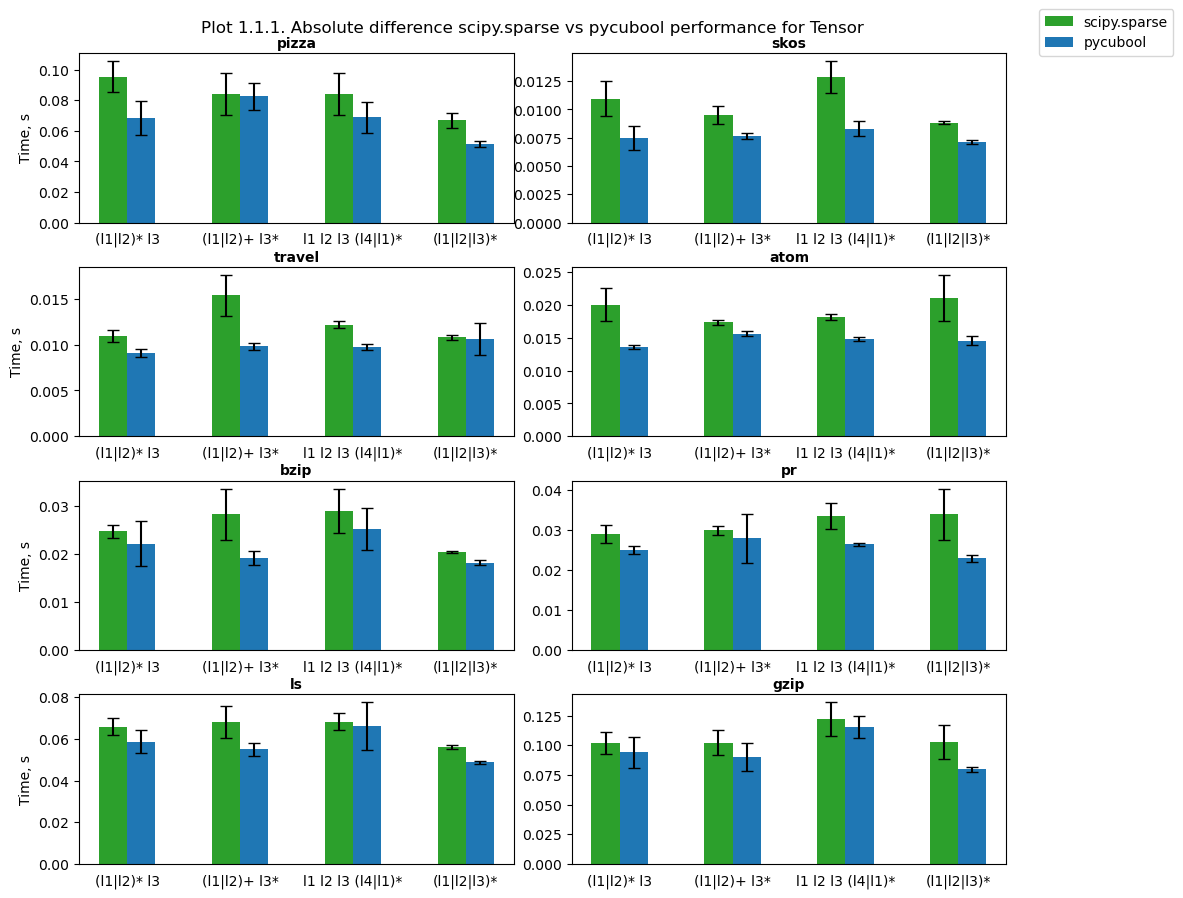

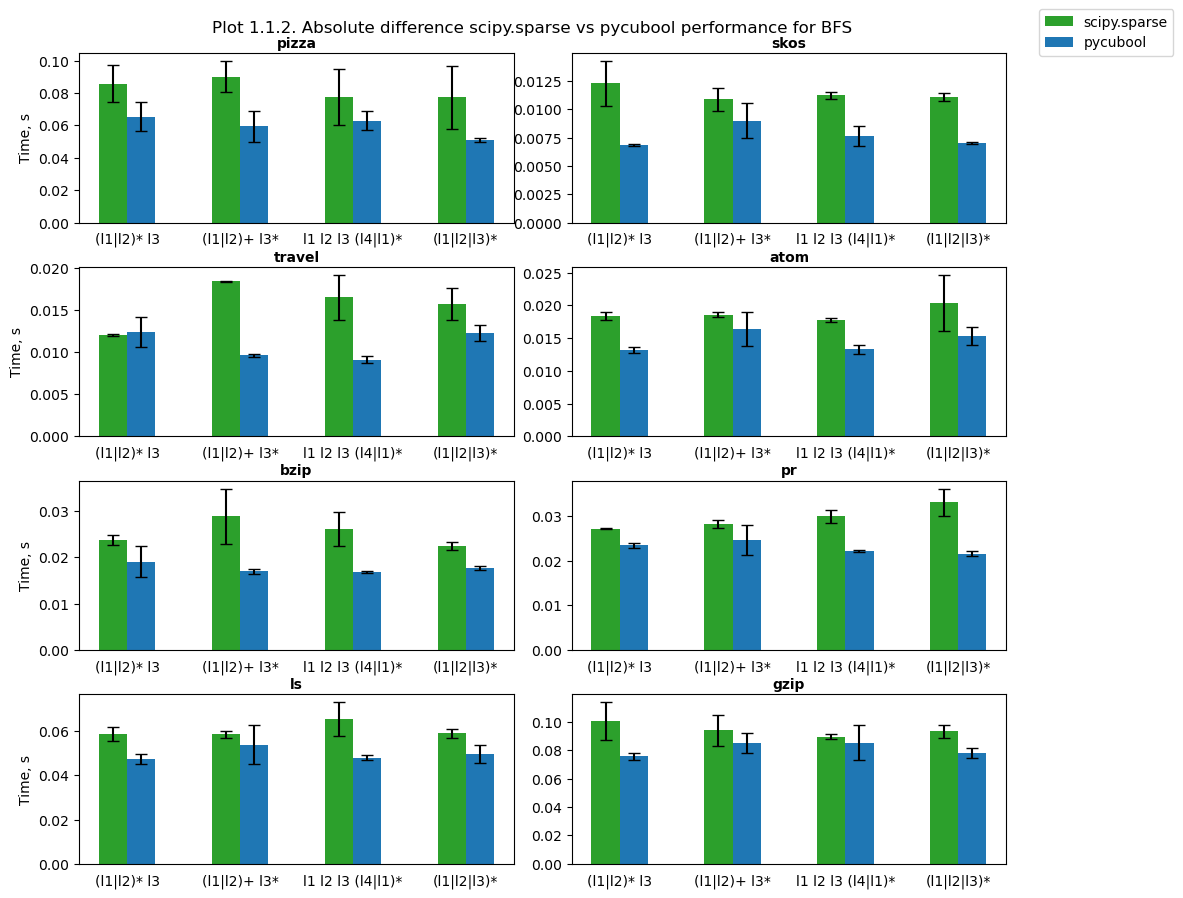

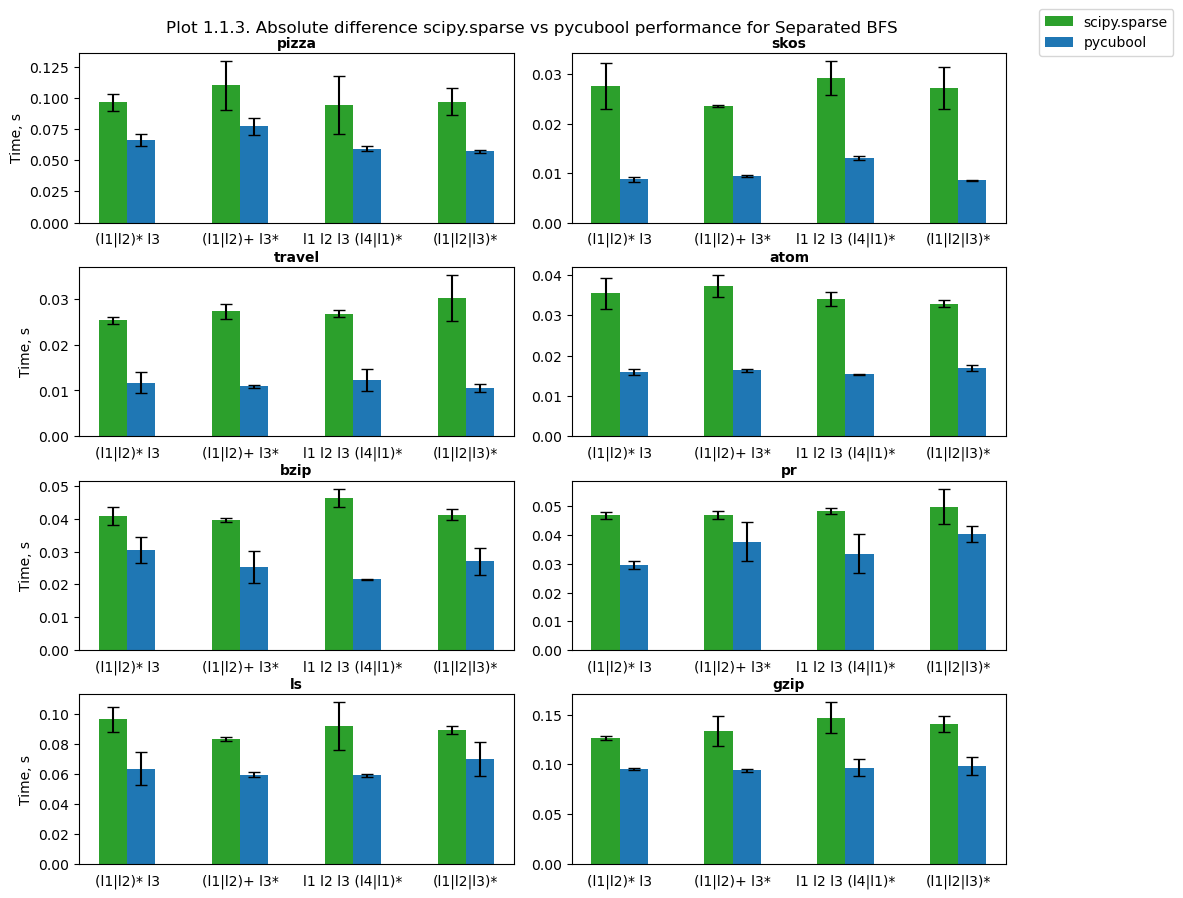

In [18]:
def batch_plots_1(res):
    fig_size = (2.5 * len(REGEXES_STR), len(GRAPHS))
    label_locations = np.arange(len(REGEXES_STR))
    bar_width = 0.25
    cap_size = 4

    for algo_i, algo_name in enumerate(ALGORITHMS):
        fig: plt.Figure
        fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

        fig.suptitle(
            f"Plot 1.1.{algo_i + 1}. Absolute difference scipy.sparse vs pycubool performance for {algo_name}")
        fig.tight_layout()

        for g_i, ax in enumerate(axs.flat):
            graph_name = GRAPHS[g_i].name
            graph_results = res[g_i]

            ax.set_xlabel(graph_name, weight="bold")
            ax.xaxis.set_label_position("top")

            ax.set_xticks(label_locations, REGEXES_STR)
            ax.tick_params(axis='x', which='both', bottom=False)
            if not g_i % len(axs[0]):
                ax.set_ylabel("Time, s")

            scipy_means = [rs[0][algo_i][0] for rs in graph_results]
            scipy_stdevs = [rs[0][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations - bar_width / 2,
                scipy_means,
                bar_width,
                yerr=scipy_stdevs,
                color="tab:green",
                label="scipy.sparse",
                capsize=cap_size,
            )

            pycubool_means = [rs[1][algo_i][0] for rs in graph_results]
            pycubool_stdevs = [rs[1][algo_i][1] for rs in graph_results]
            ax.bar(
                label_locations + bar_width / 2,
                pycubool_means,
                bar_width,
                yerr=pycubool_stdevs,
                color="tab:blue",
                label="pycubool",
                capsize=cap_size,
            )

        handles, labels = axs[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_1(fixed_starts_res)

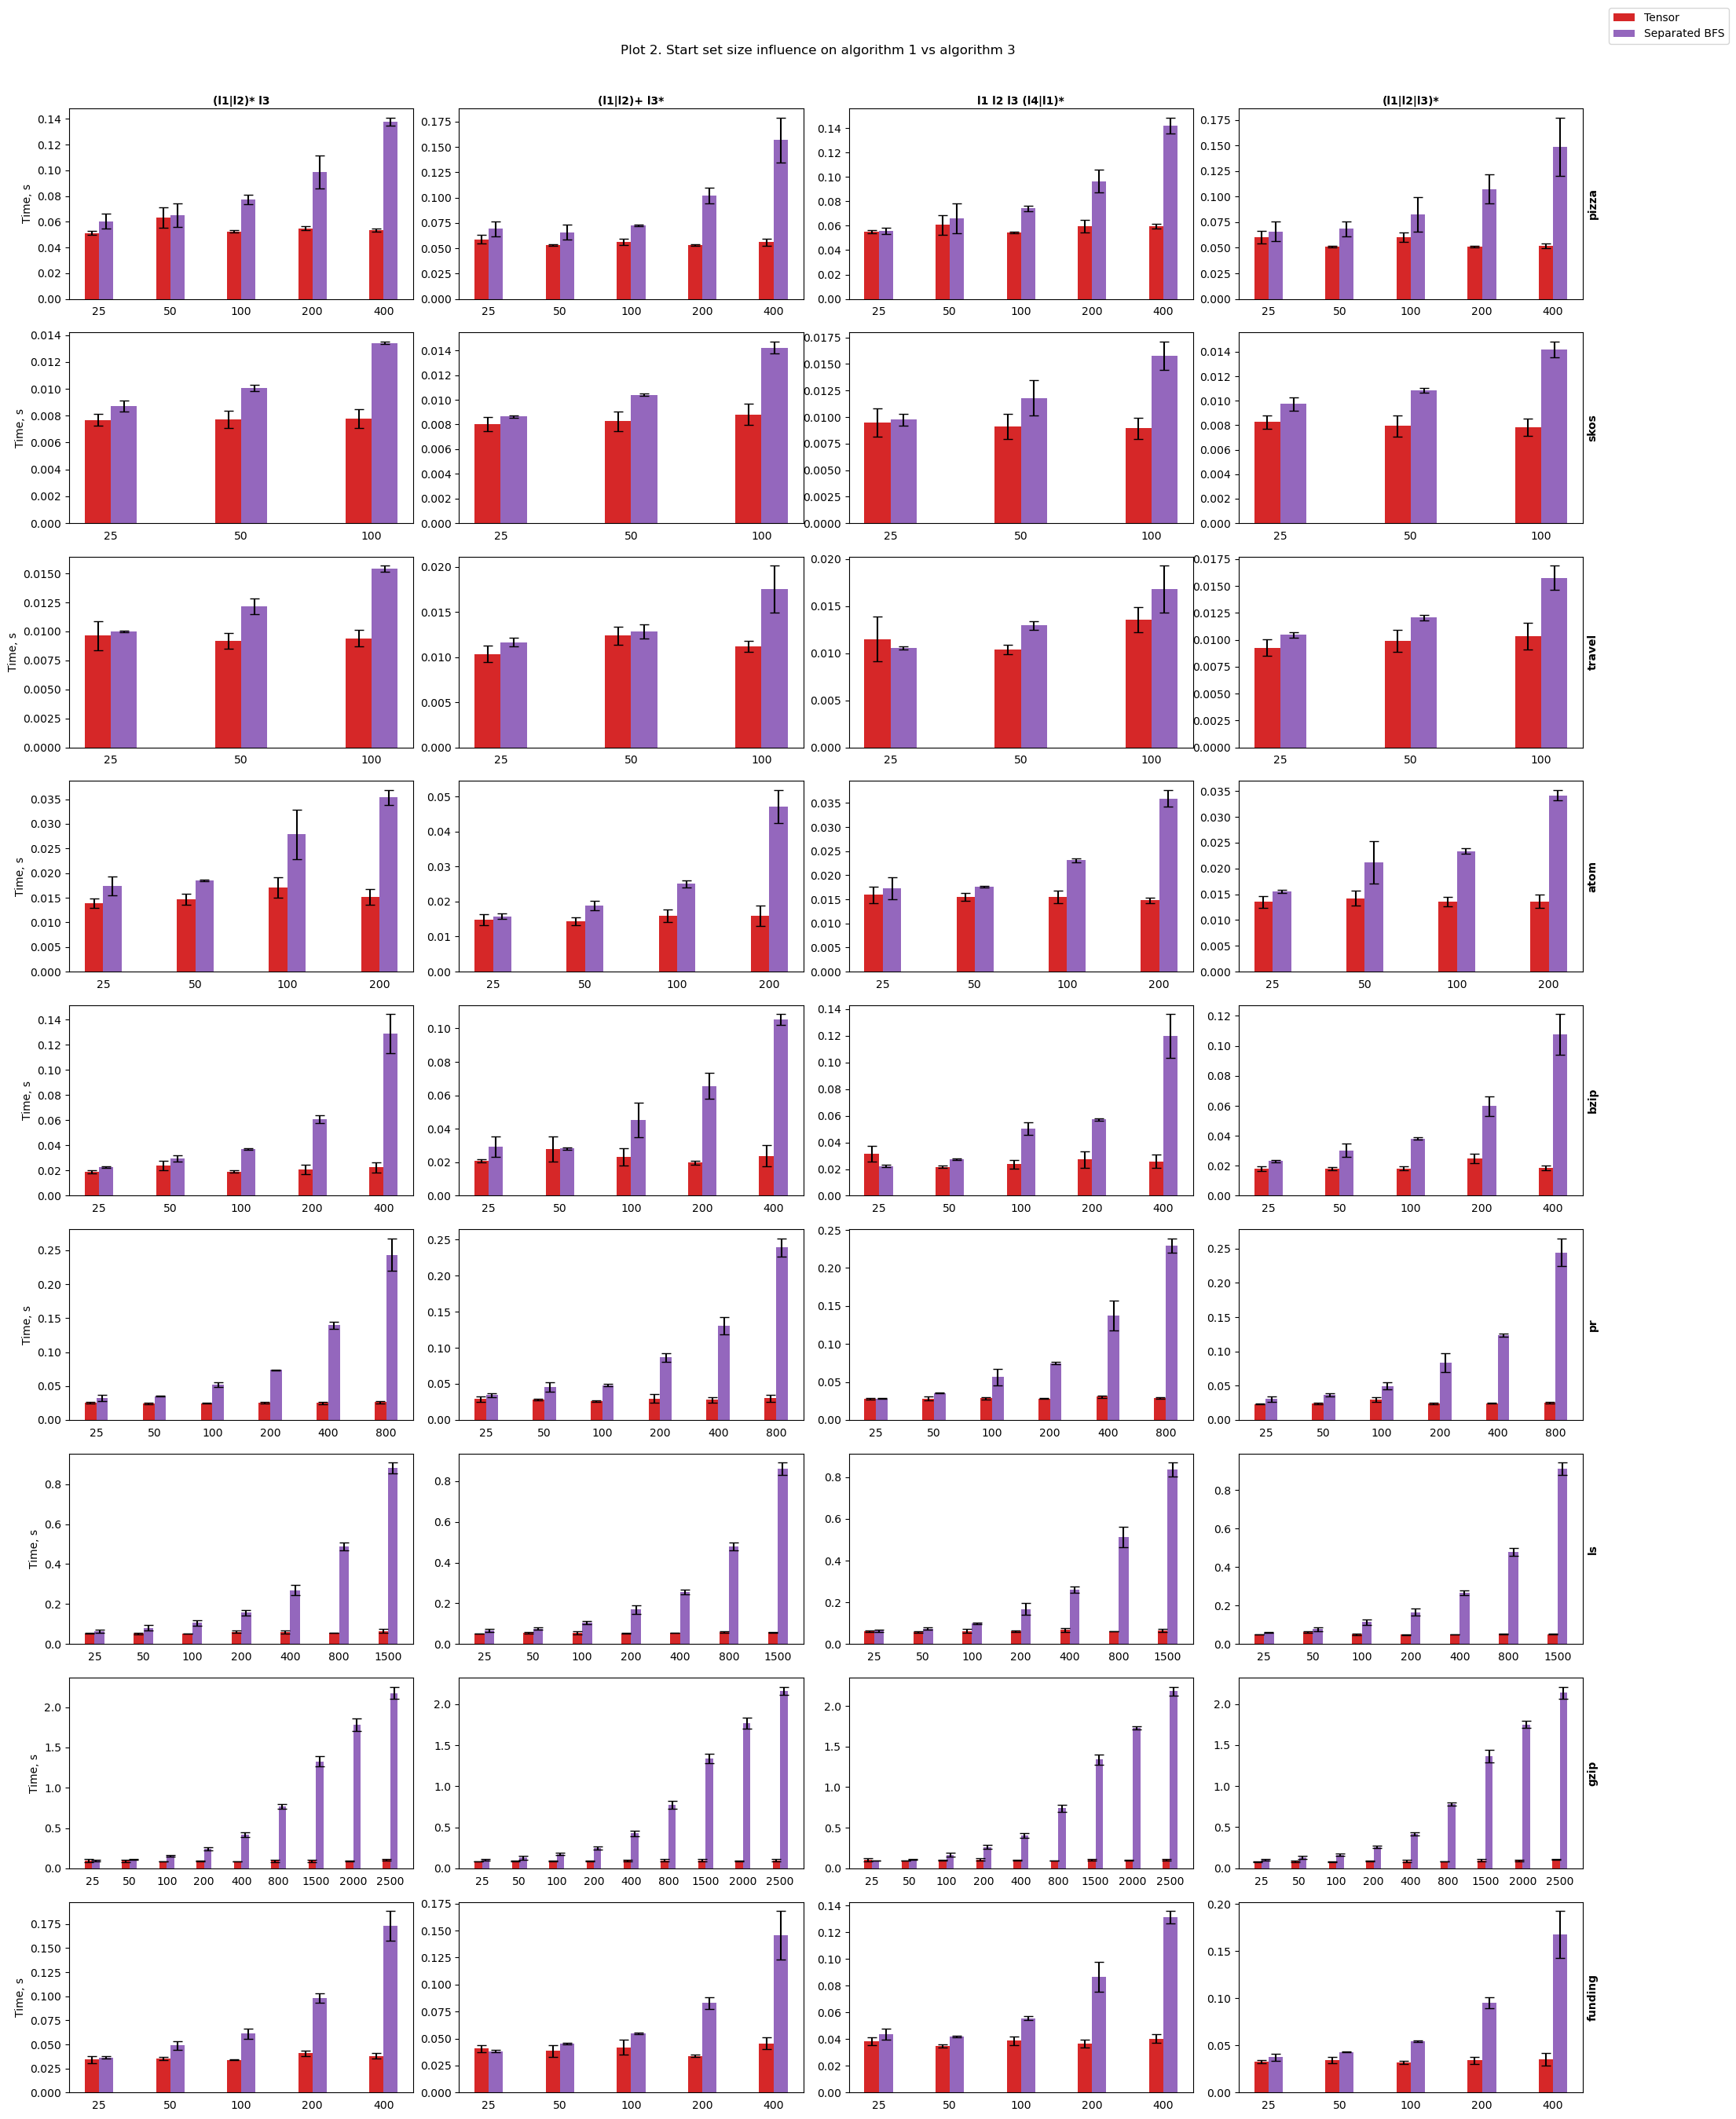

In [19]:
def batch_plots_2(res):
    fig, axs = plt.subplots(len(GRAPHS), len(REGEXES_STR), figsize=(5 * len(REGEXES_STR), 3 * len(GRAPHS)))

    fig.suptitle("Plot 2. Start set size influence on algorithm 1 vs algorithm 3")
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    bar_width = 0.2
    cap_size = 4

    for g_i, axs_row in enumerate(axs):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        for r_i, ax in enumerate(axs_row):
            regex_name = list(REGEXES_STR)[r_i]
            regex_results = graph_results[r_i]

            if not g_i:
                ax.set_xlabel(regex_name, weight="bold")
                ax.xaxis.set_label_position("top")

            if not r_i:
                ax.set_ylabel("Time, s")

            if r_i == len(REGEXES_STR) - 1:
                ax.set_ylabel(graph_name, weight="bold")
                ax.yaxis.set_label_position("right")

            label_locations = np.arange(len(regex_results))
            ax.set_xticks(label_locations, regex_results.keys())

            algo1_results = [rs[0] for rs in regex_results.values()]
            algo1_means, algo1_stdevs = zip(*algo1_results)
            ax.bar(
                label_locations - bar_width / 2,
                algo1_means,
                bar_width,
                yerr=algo1_stdevs,
                color="tab:red",
                label=ALGORITHMS[0],
                capsize=cap_size,
            )

            algo3_results = [rs[1] for rs in regex_results.values()]
            algo3_means, algo3_stdevs = zip(*algo3_results)
            ax.bar(
                label_locations + bar_width / 2,
                algo3_means,
                bar_width,
                yerr=algo3_stdevs,
                color="tab:purple",
                label=ALGORITHMS[2],
                capsize=cap_size,
            )

            ax.tick_params(axis='x', which='both', bottom=False)

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_2(varied_starts_res)

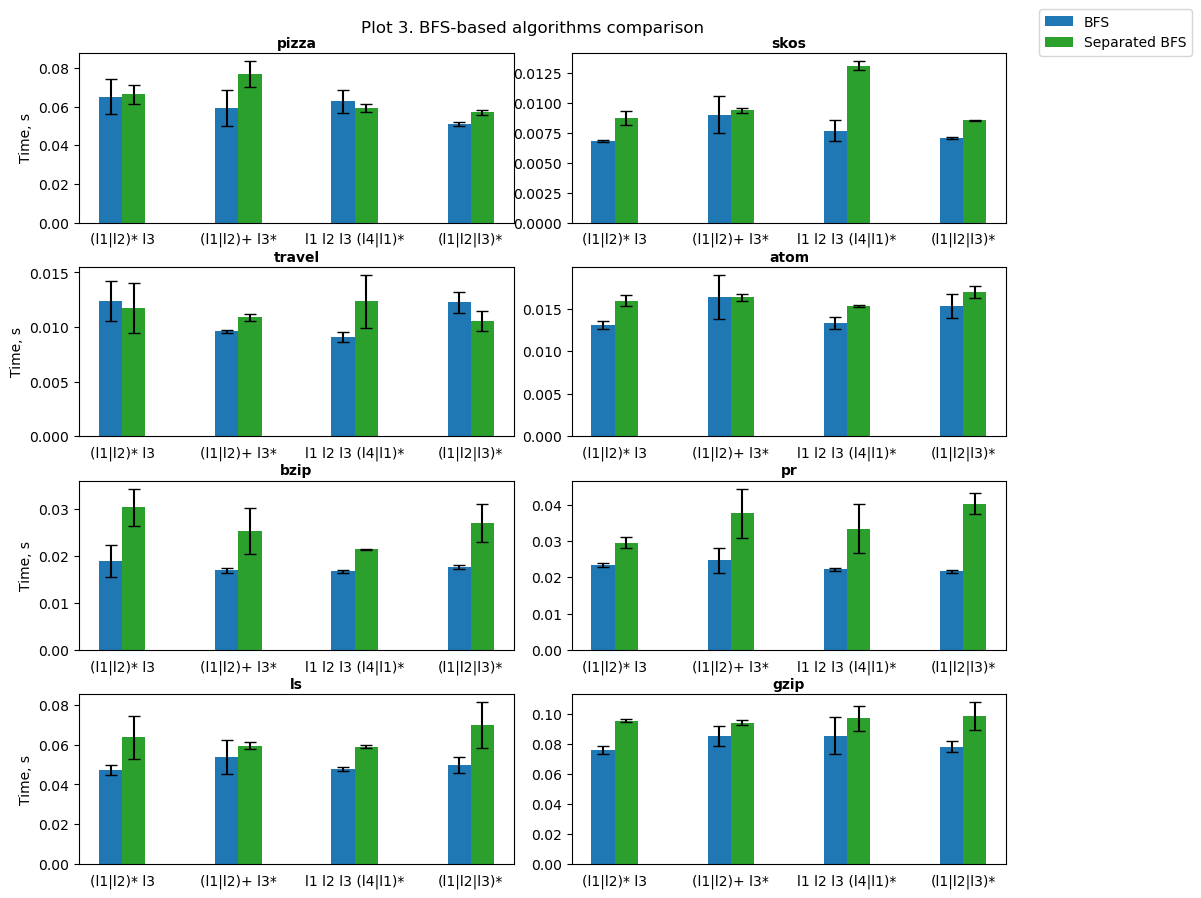

In [20]:
def batch_plots_3(res):
    fig_size = (2.5 * len(REGEXES_STR), len(GRAPHS))
    label_locations = np.arange(len(REGEXES_STR))
    bar_width = 0.2
    cap_size = 4

    fig, axs = plt.subplots(len(GRAPHS) // 2, 2, figsize=fig_size)

    fig.suptitle("Plot 3. BFS-based algorithms comparison")
    fig.tight_layout()

    for g_i, ax in enumerate(axs.flat):
        graph_name = GRAPHS[g_i].name
        graph_results = res[g_i]

        ax.set_xlabel(graph_name, weight="bold")
        ax.xaxis.set_label_position("top")

        ax.set_xticks(label_locations, REGEXES_STR)
        ax.tick_params(axis='x', which='both', bottom=False)
        if not g_i % len(axs[0]):
            ax.set_ylabel("Time, s")

        pycubool_algo2_means = [rs[1][1][0] for rs in graph_results]
        pycubool_algo2_stdevs = [rs[1][1][1] for rs in graph_results]
        ax.bar(
            label_locations - bar_width / 2,
            pycubool_algo2_means,
            bar_width,
            yerr=pycubool_algo2_stdevs,
            color="tab:blue",
            label=ALGORITHMS[1],
            capsize=cap_size,
        )

        pycubool_algo3_means = [rs[1][2][0] for rs in graph_results]
        pycubool_algo3_stdevs = [rs[1][2][1] for rs in graph_results]
        ax.bar(
            label_locations + bar_width / 2,
            pycubool_algo3_means,
            bar_width,
            yerr=pycubool_algo3_stdevs,
            color="tab:green",
            label=ALGORITHMS[2],
            capsize=cap_size,
        )

    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()


batch_plots_3(fixed_starts_res)